In [1]:
model_name = "Original_Pretrained_R2plus1DMotionSegNet.pth"

# model_name = "dropout_v2_0_25_R2plus1DMotionSegNet.pth"
# model_name = "dropout_v3_0_10_R2plus1DMotionSegNet.pth"

In [2]:
import os
os.chdir("../..")
print(os.getcwd())

%config Completer.use_jedi = False

import SimpleITK as itk
from LabelFusion.wrapper import fuse_images

import echonet
from echonet.datasets import Echo

import torch.nn.functional as F
from torchvision.models.video import r2plus1d_18
from torch.utils.data import Dataset, DataLoader, Subset
from multiprocessing import cpu_count

from src.utils.torch_utils import TransformDataset, torch_collate
from src.utils.echo_utils import get2dPucks
from src.utils.camus_validate import cleanupSegmentation
from src.transform_utils import generate_2dmotion_field
from src.visualization_utils import categorical_dice
from src.loss_functions import huber_loss, convert_to_1hot, convert_to_1hot_tensor
from src.echonet_dataset import EDESpairs, EchoNetDynamicDataset

from src.model.R2plus1D_18_MotionNet import R2plus1D_18_MotionNet

# v2 dropout (in place before motion heads, forgot to define in forward pass function, but still saw diff, weird.)
from src.model.dropout_v2_0_00_R2plus1D_18_MotionNet import dropout_v2_0_00_R2plus1D_18_MotionNet
from src.model.dropout_v2_0_10_R2plus1D_18_MotionNet import dropout_v2_0_10_R2plus1D_18_MotionNet
from src.model.dropout_v2_0_25_R2plus1D_18_MotionNet import dropout_v2_0_25_R2plus1D_18_MotionNet
from src.model.dropout_v2_0_50_R2plus1D_18_MotionNet import dropout_v2_0_50_R2plus1D_18_MotionNet
from src.model.dropout_v2_0_75_R2plus1D_18_MotionNet import dropout_v2_0_75_R2plus1D_18_MotionNet
# v3 dropout (one dropout layer defined in forward pass func, this should've been the correct way to do it.)
from src.model.dropout_v3_0_00_R2plus1D_18_MotionNet import dropout_v3_0_00_R2plus1D_18_MotionNet
from src.model.dropout_v3_0_10_R2plus1D_18_MotionNet import dropout_v3_0_10_R2plus1D_18_MotionNet
from src.model.dropout_v3_0_25_R2plus1D_18_MotionNet import dropout_v3_0_25_R2plus1D_18_MotionNet
from src.model.dropout_v3_0_50_R2plus1D_18_MotionNet import dropout_v3_0_50_R2plus1D_18_MotionNet
from src.model.dropout_v3_0_75_R2plus1D_18_MotionNet import dropout_v3_0_75_R2plus1D_18_MotionNet
# v4 dropout (4 dropout layers in different places in the forward func, I'm going to guess more "generalizable")
from src.model.dropout_v4_0_00_R2plus1D_18_MotionNet import dropout_v4_0_00_R2plus1D_18_MotionNet
from src.model.dropout_v4_0_10_R2plus1D_18_MotionNet import dropout_v4_0_10_R2plus1D_18_MotionNet
from src.model.dropout_v4_0_25_R2plus1D_18_MotionNet import dropout_v4_0_25_R2plus1D_18_MotionNet
from src.model.dropout_v4_0_50_R2plus1D_18_MotionNet import dropout_v4_0_50_R2plus1D_18_MotionNet
from src.model.dropout_v4_0_75_R2plus1D_18_MotionNet import dropout_v4_0_75_R2plus1D_18_MotionNet

# for finding lv seg borders
import cv2 as cv


# from src.visualization_utils import categorical_dice

import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import random
import pickle
import time

tic, toc = (time.time, time.time)


device = 'cuda' if torch.cuda.is_available() else 'cpu'
device


batch_size = 4
num_workers = max(4, cpu_count()//2)


def worker_init_fn_valid(worker_id):                                                          
    np.random.seed(np.random.get_state()[1][0] + worker_id)
    

def worker_init_fn(worker_id):
    # See here: https://pytorch.org/docs/stable/notes/randomness.html#dataloader
    # and the original post of the problem: https://github.com/pytorch/pytorch/issues/5059#issuecomment-817373837
    worker_seed = torch.initial_seed() % 2 ** 32
    print(f'worker_seed: {worker_seed}')
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    

def permuter(list1, list2):
    for i1 in list1:
        for i2 in list2:
            yield (i1, i2)
            

param_trainLoader = {'collate_fn': torch_collate,
                     'batch_size': batch_size,
                     'num_workers': max(4, cpu_count()//2),
                     'worker_init_fn': worker_init_fn}

param_testLoader = {'collate_fn': torch_collate,
                    'batch_size': batch_size,
                    'shuffle': False,
                    'num_workers': max(4, cpu_count()//2),
                    'worker_init_fn': worker_init_fn}

paramLoader = {'train': param_trainLoader,
               'valid': param_testLoader,
               'test':  param_testLoader}


with open("fold_indexes/stanford_valid_sampled_indices", "rb") as infile:
    valid_mask = pickle.load(infile)
infile.close()

# full_dataset = EchoNetDynamicDataset(split='val', clip_length="full", subset_indices=valid_mask, period=1)
test_dataset = EchoNetDynamicDataset(split='test', clip_length="full", raise_for_es_ed=False, period=1)
# random_test_dataset = EchoNetDynamicDataset(split='test', clip_length=32, raise_for_es_ed=True, period=1)

/home/wang/workspace/JupyterNoteBooksAll/fully-automated-multi-heartbeat-echocardiography-video-segmentation-and-motion-tracking


100%|██████████| 16/16 [00:01<00:00, 14.01it/s]


In [3]:
model_save_path = f"save_models/{model_name}"
    
if model_name == 'Original_Pretrained_R2plus1DMotionSegNet.pth':
    model_template_obj = R2plus1D_18_MotionNet()
elif model_name == 'dropout_v2_0_00_R2plus1DMotionSegNet.pth':
    model_template_obj = dropout_v2_0_00_R2plus1D_18_MotionNet()
elif model_name == 'dropout_v2_0_10_R2plus1DMotionSegNet.pth':
    model_template_obj = dropout_v2_0_10_R2plus1D_18_MotionNet()

elif model_name == "dropout_v3_0_00_R2plus1DMotionSegNet.pth":
    model_template_obj = dropout_v3_0_00_R2plus1D_18_MotionNet()
elif model_name == "dropout_v3_0_10_R2plus1DMotionSegNet.pth":
    model_template_obj = dropout_v3_0_10_R2plus1D_18_MotionNet()
elif model_name == "dropout_v3_0_25_R2plus1DMotionSegNet.pth":
    model_template_obj = dropout_v3_0_25_R2plus1D_18_MotionNet()
elif model_name == "dropout_v4_0_00_R2plus1DMotionSegNet.pth":
    model_template_obj = dropout_v4_0_00_R2plus1D_18_MotionNet()
elif model_name == "dropout_v4_0_10_R2plus1DMotionSegNet.pth":
    model_template_obj = dropout_v4_0_10_R2plus1D_18_MotionNet()
elif model_name == "dropout_v4_0_25_R2plus1DMotionSegNet.pth":
    model_template_obj = dropout_v4_0_25_R2plus1D_18_MotionNet()


model = torch.nn.DataParallel(model_template_obj)

model.to("cuda")
torch.cuda.empty_cache()
model.load_state_dict(torch.load(model_save_path)["model"])
print(f'{model_name} has {sum(p.numel() for p in model.parameters() if p.requires_grad)} parameters.')
model.eval();

Original_Pretrained_R2plus1DMotionSegNet.pth has 31575731 parameters.


In [4]:
from src.strain import *

In [5]:
%matplotlib widget

In [6]:
test_pat_index = 0
clip_index = 0
which_direction = [0,1,2,3]
out_file_comment = ""

curr_clip_segmentations, curr_clip_motions, delta_ed_es, clip_index, ed_label, es_label = get_seg_and_warp_data(model = model,
                                                                                            test_dataset = test_dataset,
                                                                                            test_pat_index = test_pat_index)

In [7]:
curr_clip_motions.shape

(4, 32, 112, 112)

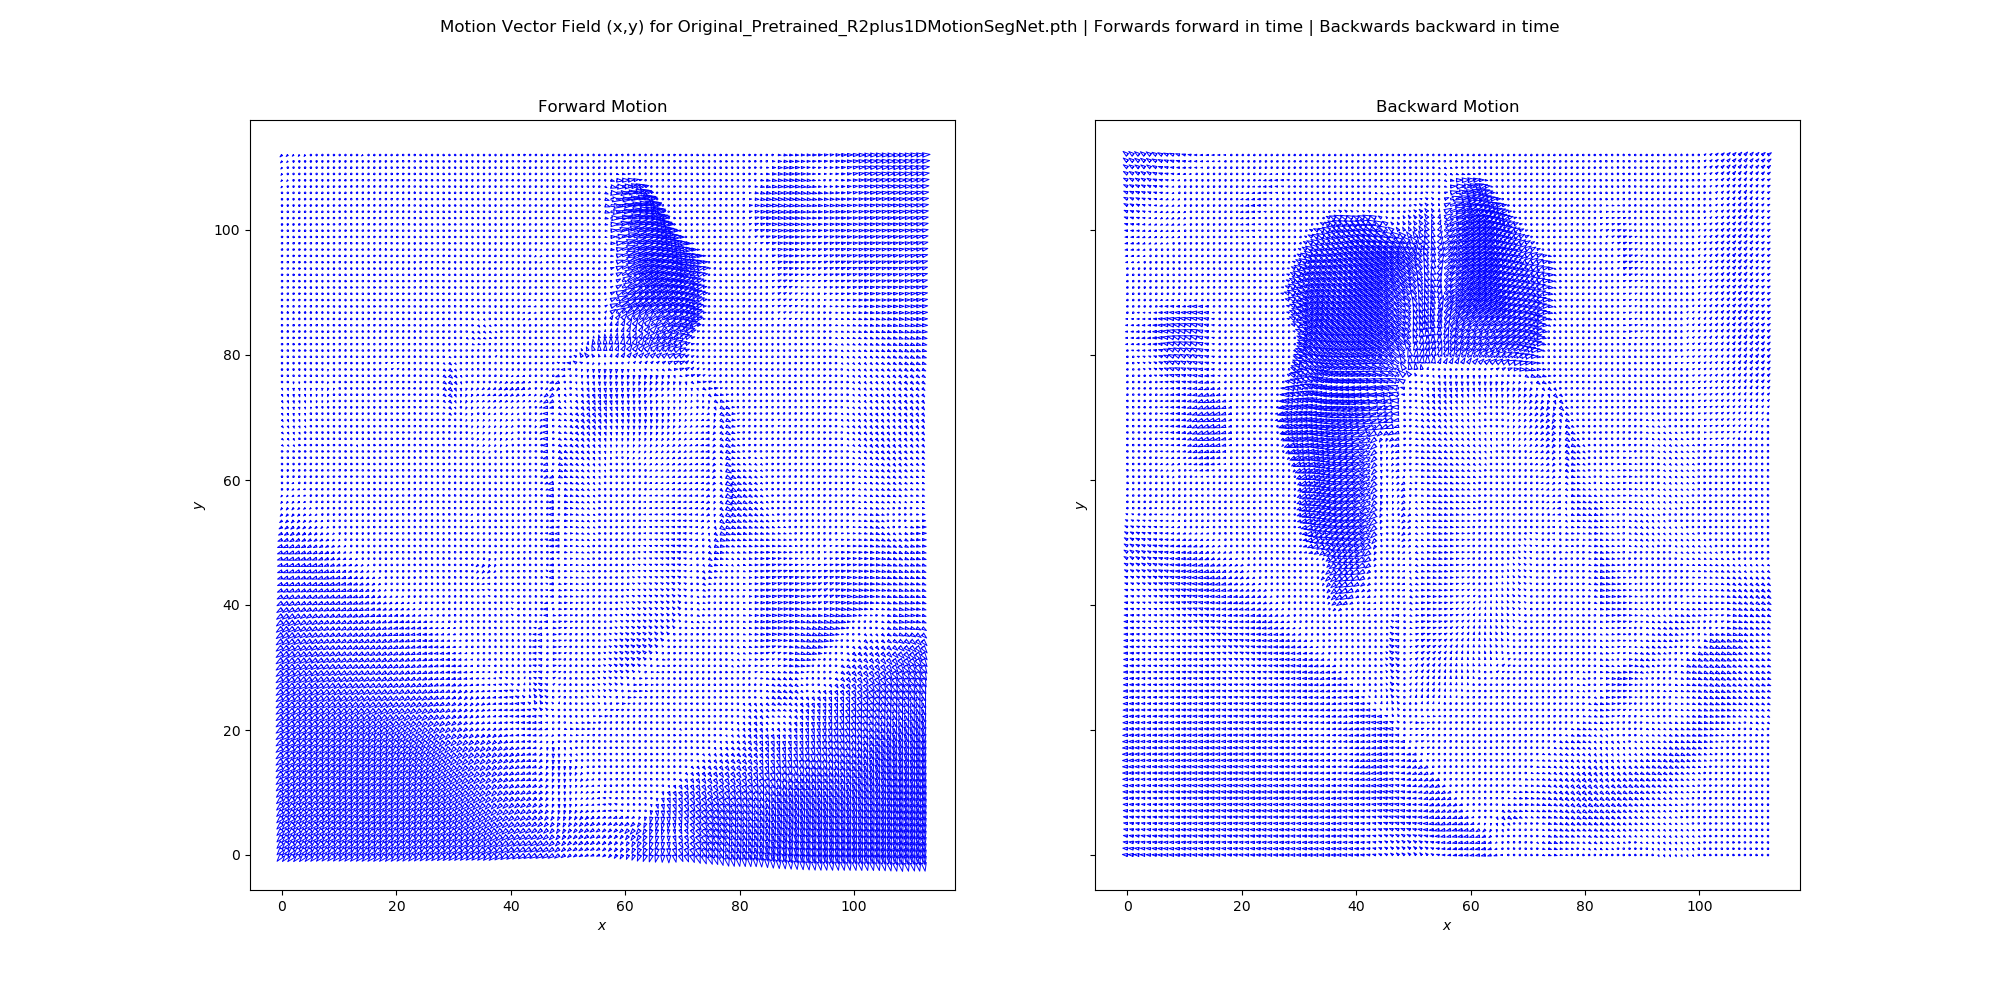

In [8]:
# for creating gif animation and viewing them
from matplotlib import animation
from IPython.display import Image
from matplotlib.widgets import Slider, Button


motion_output_obj = curr_clip_motions

shared = True

# 2 subplots, forward and backward motion
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10), sharex = shared, sharey = shared);

# starting frame ind
start_frame = 0

# get initial forward and backward motion
fx = motion_output_obj[which_direction[0]][start_frame]
fy = motion_output_obj[which_direction[1]][start_frame]

bx = motion_output_obj[which_direction[2]][31 - start_frame]
by = motion_output_obj[which_direction[3]][31 - start_frame]

# create values for the tails of the vectors (these don't need to change)
nrows, ncols = fx.shape
x_tmp = np.linspace(0, 112, ncols)  
y_tmp = np.linspace(0, 112, nrows)
x_tails, y_tails = np.meshgrid(x_tmp, y_tmp, indexing='xy')

# put titles, axes on subplots
plt.suptitle(f"Motion Vector Field (x,y) for {model_name} | Forwards forward in time | Backwards backward in time")

ax1.set_title('Forward Motion')
ax1.set_xlabel('$x$')
ax1.set_ylabel('$y$')
# ax1.invert_yaxis()

ax2.set_title('Backward Motion')
ax2.set_xlabel('$x$')
ax2.set_ylabel('$y$')
# ax2.invert_yaxis()

# put initial magnitudes to the vectors with fixed tails
# forward
ax1.quiver(x_tails, y_tails, fx, fy, edgecolor='b', facecolor='none', linewidth=0.7);
# backward
ax2.quiver(x_tails, y_tails, bx, by, edgecolor='b', facecolor='none', linewidth=0.7);


# # funct to update imshow with new frame of motion output
# def animate(frame):
#     # update forward xy and backward xy
#     fx = motion_output_obj[which_direction[0]][frame]
#     fy = motion_output_obj[which_direction[1]][frame]

#     bx = motion_output_obj[which_direction[2]][31 - frame]
#     by = motion_output_obj[which_direction[3]][31 - frame]

#     # clear forward and backward axes first (we'll need to reapply the labels and inverting the y axis)
#     ax1.clear()
#     ax2.clear()
#     ax1.set_title('Forward Motion')
#     ax1.set_xlabel('$x$')
#     ax1.set_ylabel('$y$')
#     # ax1.invert_yaxis()

#     ax2.set_title('Backward Motion')
#     ax2.set_xlabel('$x$')
#     ax2.set_ylabel('$y$')
#     # ax2.invert_yaxis()

#     # update the magnitudes of the vectors with fixed tails
#     # forward
#     ax1.quiver(x_tails, y_tails, fx, fy, edgecolor='b', facecolor='none', linewidth=0.7);
#     # backward|
#     ax2.quiver(x_tails, y_tails, bx, by, edgecolor='b', facecolor='none', linewidth=0.7);


# anim = animation.FuncAnimation(fig, animate, np.arange(0, 32), interval=500, blit=True); # interval is milliseconds between each redraw, adjusts animation speed